# Model comparison / model selection
## using the Akaike Information Criterion and Bayesian Information Criterion

In [1]:
# import all packages we will need in this notebook
import pandas
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize

In [2]:
# read in some data we created for this example (.dat is a generic filename, it's just a text file)
data_filename='https://raw.githubusercontent.com/uofscphysics/STEM_Python_Course/Summer2020/02_Week2/Data/1D_intro_examples.dat'
example_data_1D = pandas.read_csv(data_filename,sep=',',header=0)#this file is separated by spaces and its first line contains the names of the columns (header) 
print(example_data_1D.head())

   Unnamed: 0         x           y      error
0           0  0.000000   -1.543621   5.050000
1           1  0.714286   13.432917   6.709184
2           2  1.428571   45.895726  11.343878
3           3  2.142857  158.160689  18.954082
4           4  2.857143  212.872646  29.539796


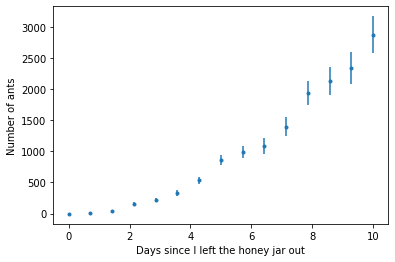

In [3]:
#Let's plot the data, with error bars, that we read from file (See Day 2)
plt.errorbar(example_data_1D['x'], #x,y,and error are the column names
             example_data_1D['y'], 
             yerr=example_data_1D['error'],#yerr denotes an error in the y-direction for plotting
             fmt='.') #fmt is "format", saying that I want data marked by "points"
plt.xlabel('Days since I left the honey jar out') #set the x-axis label 
plt.ylabel('Number of ants') #set the y-axis label
plt.show()

In [4]:
#The data were generated with a simple quadratic equation:
#ax^2+bx+c. 
def modelA_quadratic(x, alpha, beta, gamma): 
    """A quadratic in x (this happens to be the true model)"""
    return(alpha*x**2 + beta*x + gamma)

def modelB_cubic(x, p0, p1, p2, p3):
    """A third-order polynomial model."""
    return( p0 + p1*x + p2*x**2 + p3*x**3)
    
def modelC_exponential(x, floor, scale, expfactor):
    """"""
    return( floor + scale * np.exp( expfactor * x) )


In [5]:
def neg_ln_likelihoodA_quadratic(theta, args):
    """ This function accepts an argument "theta", which is 
    a list of parameter values [alpha,beta,gamma] for model A.
    It then calculates a log-likelihood by computing the 
    chi-squared statistic (i.e., assuming gaussian uncertainties), 
    which compares the observations and errors (provided in args) 
    to the model A.
    """   
    x, y, yerr = args 
    alpha, beta, gamma = theta 
    
    model_at_observed_x = modelA_quadratic(x, alpha, beta, gamma) 
    inverse_uncertainty2 = 1./yerr**2 
    chisquared = np.sum((y - model_at_observed_x)**2 
                        * inverse_uncertainty2 )
    # When all uncertainties are gaussian and uncorrelated, the 
    # natural log of the likelihood is ln(likelihood) = -0.5 * chi2 
    # We want -ln(likelihood) so we return 0.5*chi2.
    return (0.5 * chisquared)

In [6]:
def neg_ln_likelihoodB_cubic(theta, args):
    """ This function accepts an argument "theta", which is 
    a list of parameter values [p0,p1,p2,p3] for model B 
    (the cubic model).
    It then calculates a log-likelihood by computing the 
    chi-squared statistic (i.e., assuming gaussian uncertainties), 
    which compares the observations and errors (provided in args) 
    to the model B.
    """   
    x, y, yerr = args 

    # Introducing a short-hand here, to pass a list 
    # as distinct arguments to a function, pass *name_of_list
    model_at_observed_x = modelB_cubic(x, *theta) 
    
    # that is equivalent to doing: 
    # p0, p1, p2, p3 = theta 
    # model_at_observed_x = modelB_quartic(x, p0, p1, p2, p3)

    inverse_uncertainty2 = 1./yerr**2 
    chisquared = np.sum((y - model_at_observed_x)**2 
                        * inverse_uncertainty2 )
    return (0.5 * chisquared)

In [7]:
def neg_ln_likelihoodC_exponential(theta, args):
    """ This function accepts an argument "theta", which is 
    a list of parameter values [floor, scale, k] for model C 
    (the exponential model).
    It then calculates a log-likelihood by computing the 
    chi-squared statistic (i.e., assuming gaussian uncertainties), 
    which compares the observations and errors (provided in args) 
    to the model C.
    """   
    x, y, yerr = args 
    
    model_at_observed_x = modelC_exponential(x, *theta) 
    inverse_uncertainty2 = 1./yerr**2 
    chisquared = np.sum((y - model_at_observed_x)**2 
                        * inverse_uncertainty2 )
    return (0.5 * chisquared)

Let's have a look at what these models look like, using some parameters that are in the right ball park

In [8]:
def plot_three_models(thetaA, thetaB, thetaC):
    """ Plot all three models over the data, using 
    three parameter sets thetaA, thetaB and thetaC"""
    # first plot the data
    plt.errorbar(example_data_1D['x'], example_data_1D['y'], 
             yerr=example_data_1D['error'],
             fmt='.') 
    plt.xlabel('Days since I left the honey jar out')
    plt.ylabel('Number of ants')

    # now plot the models
    x_for_plotting = np.arange(-0.02, 10.1, 0.1)
    plt.plot(x_for_plotting, 
             modelA_quadratic(x_for_plotting, *thetaA),
             color='b', label='A (quadratic)')
         
    plt.plot(x_for_plotting, 
             modelB_cubic(x_for_plotting, *thetaB),
             color='g', label='B (cubic)')

    plt.plot(x_for_plotting, 
             modelC_exponential(x_for_plotting, *thetaC),
             color='m', label='C (exponential)')

    plt.legend()
    plt.show()

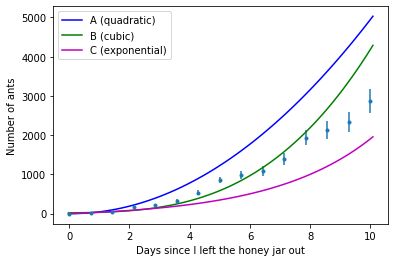

In [9]:
plot_three_models([50, -5, 1], [20, 10, 0.7, 4], [-100,100,0.3])

### Find the best parameters for each model.
Use the scipy minimizer to find the minimum -ln(likelihood).
In this case, this is equivalent to "maximum likelihood estimation"
or "chi2 minimization". 


In [10]:
# use scipy.optimize.minimize to find the minimum -ln(likelihood)
# for each of our three models

neglnlike_min_resultA = scipy.optimize.minimize(
    neg_ln_likelihoodA_quadratic, 
    x0=[20,-1,-1],
    bounds=None, #[(-100,100),(-100,100),(0,100)], 
    args=[example_data_1D['x'],
          example_data_1D['y'],
          example_data_1D['error']])

neglnlike_min_resultB = scipy.optimize.minimize(
    neg_ln_likelihoodB_cubic, 
    x0=[20, 10, 0.7, 0.3],
    bounds=None,
    args=[example_data_1D['x'],
          example_data_1D['y'],
          example_data_1D['error']])

neglnlike_min_resultC = scipy.optimize.minimize(
    neg_ln_likelihoodC_exponential, 
    x0=[-100, 200, 1],
    bounds=None,
    args=[example_data_1D['x'],
          example_data_1D['y'],
          example_data_1D['error']])

In [11]:
# Print out the results: the parameters that give the
# minimum -ln(likelihood) for each model
# (note that the scipy minimizer uses 'x' as the key for 
#  the best-fit parameters and 'fun' for the best-fit value
#  of the function being minimized)
print(neglnlike_min_resultA['x'])
print(neglnlike_min_resultB['x'])
print(neglnlike_min_resultC['x'])

[29.15908744 -0.87102224 -1.77518517]
[-1.12704349 -5.41696833 31.91586375 -0.296965  ]
[-190.06197701  176.01227151    0.30124996]


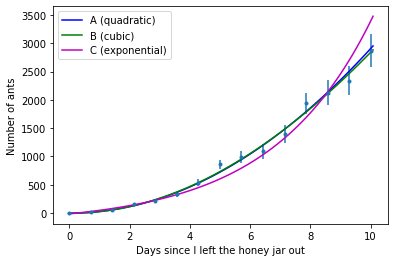

In [12]:
# Plot the "best-fit" curve for each model
plot_three_models(neglnlike_min_resultA['x'], 
                  neglnlike_min_resultB['x'], 
                  neglnlike_min_resultC['x'])

# Model comparison :  the AIC and BIC 

The Akaike information criterion is defined as:

### AIC = 2 k - 2 ln(L)

it balances a model's ability to fit the data (measured by the maximum likelihood value L) against the number of parameters 'k' that the model requires.  A smaller value of the AIC indicates a better model (i.e., one that matches the data well, without being unnecessarily complex).

The Bayesian information criterion is very similar. It replaces the 2 in the first term with ln(n), where n is the number of data points.  This puts more weight on the first term (which penalizes complexity) when the size of the sample is large.  As with the AIC, smaller is better.

### BIC = k ln( n ) - 2 ln( L )

These two metrics are the most commonly used, but many others exist, with subtle differences in their properties.  One should take care to apply the appropriate criteria based on the data, the models, and the problem.

In [13]:
# Let us define a function that computes the AIC and BIC for each of our three models

def aic(numparams, lnmaxlikelihood):
    return (2 * numparams - 2 * lnmaxlikelihood)


def bic(numparams, numdatapoints, lnmaxlikelihood):
    return (numparams * np.log(numdatapoints) - 2 * lnmaxlikelihood)

In [14]:
# Compute each max likelihood value and report.  

# Remember that we have found the minimum
# of the negative log likelihood for each
# function. This is reported as the 'fun'
# entry in our set of results from the 
# scipy.optimize.minimize() function calls.

# The opposite of that minimum is our maximum log likelihood.

lnlike_max_valueA = -neglnlike_min_resultA['fun']
lnlike_max_valueB = -neglnlike_min_resultB['fun']
lnlike_max_valueC = -neglnlike_min_resultC['fun']

print(lnlike_max_valueA, lnlike_max_valueB, lnlike_max_valueC)

-4.751264868757671 -4.6364399987077904 -22.127990628538438


### Compute the AIC and BIC for each model

In [15]:
aic_list = [
    aic(3, lnlike_max_valueA),
    aic(4, lnlike_max_valueB),
    aic(3, lnlike_max_valueC)]

n = len(example_data_1D)
bic_list = [
    bic(3, n, lnlike_max_valueA),
    bic(4, n, lnlike_max_valueB),
    bic(3, n, lnlike_max_valueC)]

print(aic_list)
print(bic_list)

[15.502529737515342, 17.27287999741558, 50.255981257076876]
[17.62668034082197, 20.10508080182442, 52.38013186038351]


In [16]:
# Make a nice pandas DataFrame table 

modelnames = ['A(quadratic)', 'B(cubic)', 'C(exp)']
df = pandas.DataFrame({
    'name':modelnames, 
    'AIC':aic_list, 
    'BIC':bic_list,
    'DeltaAIC':np.array(aic_list)-np.min(aic_list),
    'DeltaBIC':np.array(bic_list)-np.min(bic_list),
})

# Show the table
df

,name,AIC,BIC,DeltaAIC,DeltaBIC
0,A(quadratic),15.502530,17.626680,0.000000,0.000000
1,B(cubic),17.272880,20.105081,1.770350,2.478400
2,C(exp),50.255981,52.380132,34.753452,34.753452


In [17]:
# interpreting the AIC / BIC as statistical weight

wAIC = np.exp(-0.5 * df['DeltaAIC'])
df['wgtAIC'] = wAIC / np.sum(wAIC)

wBIC = np.exp(-0.5 * df['DeltaBIC'])
df['wgtBIC'] = wBIC / np.sum(wBIC)


# Interpreting the AIC / BIC as an odds ratio
df['oddsAIC'] = np.max(df['wgtAIC']) / df['wgtAIC']
df['oddsBIC'] = np.max(df['wgtBIC']) / df['wgtBIC']


In [18]:
# set a pandas option so we only display two decimal places
pandas.options.display.float_format = '{:.2f}'.format
df

,name,AIC,BIC,DeltaAIC,DeltaBIC,wgtAIC,wgtBIC,oddsAIC,oddsBIC
0,A(quadratic),15.50,17.63,0.00,0.00,0.71,0.78,1.00,1.00
1,B(cubic),17.27,20.11,1.77,2.48,0.29,0.22,2.42,3.45
2,C(exp),50.26,52.38,34.75,34.75,0.00,0.00,35205953.50,35205953.50


### next topic :  using the Bayesian evidence (Bayes factors) to compare models considering the entire parameter space

#### Reading list

A good broad book on Bayesian data analysis
* Sivia, D. and Skilling, J. "Data Analysis: A Bayesian Tutorial"
https://books.google.com/books/about/Data_Analysis.html?id=lYMSDAAAQBAJ

Some short "tutorial" papers about AIC / BIC: 

* Wagenmakers and Farrell 2004
https://link.springer.com/content/pdf/10.3758/BF03206482.pdf

* Symonds and Moussalli 2010
http://byrneslab.net/classes/biol607/readings/Symonds_and_Moussalli_2010_behav_ecol.pdf